# <a name="0">Analytics vidhya - Jobathon - Apr 2022</a>

In this notebook, we are performing initial data investigations to discover patterns, spot anomalies, and look for insights to inform later ML modeling choices.

1. <a href="#1">Read the dataset</a>
2. <a href="#2">Glimpse of dataset</a>
3. <a href="#3">Data preprocessing</a> 
4. <a href="#4">Univariate analysis</a> 
5. <a href="#5">Model building</a> 
6. <a href="#6">Final model</a> 
7. <a href="#7">Creating submission file</a>

__Problem Statement__

ABC is a car rental company based out of Bangalore. It rents cars for both in and out stations at affordable prices. The users can rent different types of cars like Sedans, Hatchbacks, SUVs and MUVs, Minivans and so on.

In recent times, the demand for cars is on the rise. As a result, the company would like to tackle the problem of supply and demand. The ultimate goal of the company is to strike the balance between the supply and demand inorder to meet the user expectations. 

The company has collected the details of each rental. Based on the past data, the company would like to forecast the demand of car rentals on an hourly basis. 

__Objective__

The main objective of the problem is to develop the machine learning approach to forecast the demand of car rentals on an hourly basis.


__Dataset schema:__ 

__train.csv__

It contains the hourly demand of car rentals from August 2018 to February 2021.

|Variable|Description|
|:-------:|:--------:|
|date|Date (yyyy-mm-dd)|
|hour|Hour of the day|
|demand|No. of car rentals in a hour|
 

__test.csv__

**test.csv** contains only 2 variables: date and hour. We need to predict the hourly demand of car rentals for the next 1 year i.e. from March 2021 to March 2022.

|Variable|Description|
|:-------:|:--------:|
|date|Date (yyyy-mm-dd)|
|hour|Hour of the day|

__Evaluation metric__

The evaluation metric for this hackathon is RMSE score.

$$RMSE = \sqrt{\frac{1}{n} * \sum{(y_i - \hat{y})}^2}$$

where.

 + $y_i$ is true value,
 + $\hat{y}$ is predicted value, and 

## 1. <a name="1">Read the dataset</a>
(<a href="#0">Go to top</a>)

Let's read the dataset into a dataframe, using Pandas.

In [39]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

In [40]:
# Setting pandas options for good visualization
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 100)
pd.set_option('display.precision', 4)
pd.set_option('display.float_format',  '{:,.2f}'.format)
pd.set_option('display.max_info_columns', 30)

# seaborn style for chart visualization
sns.set_style("whitegrid")

In [41]:
# Loading dataset
train = pd.read_csv('../data/train_E1GspfA.csv')
test = pd.read_csv('../data/test_6QvDdzb.csv')

print('The shape of the train dataset is:', train.shape)
print('The shape of the test dataset is:', test.shape)

The shape of the train dataset is: (18247, 3)
The shape of the test dataset is: (7650, 2)


## 2. <a name="2">Glimpse of dataset</a>
(<a href="#0">Go to top</a>)

We will look at number of rows, columns and some simple statistics of the dataset.

In [42]:
# top 5 rows - train
train.head()

,date,hour,demand
0,2018-08-18,9,91
1,2018-08-18,10,21
2,2018-08-18,13,23
3,2018-08-18,14,104
4,2018-08-18,15,81


In [43]:
# top 5 rows - test
test.head()

,date,hour
0,2021-03-01,0
1,2021-03-01,1
2,2021-03-01,2
3,2021-03-01,3
4,2021-03-01,5


In [44]:
# Let's see the data types and non-null values for each column
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18247 entries, 0 to 18246
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    18247 non-null  object
 1   hour    18247 non-null  int64 
 2   demand  18247 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 427.8+ KB


In [45]:
# columns names
print(train.columns)

Index(['date', 'hour', 'demand'], dtype='object')


In [46]:
# unique values by rach feature
train.nunique()

date      895
hour       24
demand    296
dtype: int64

In [47]:
# missing % information
train.isnull().sum()

date      0
hour      0
demand    0
dtype: int64

## 3. <a name="3">Data preprocessing</a>
(<a href="#0">Go to top</a>)

Let's create training data with 0 demand as well.

In [48]:
# data preprocessing - train
# creating unique list of date and hour
date = pd.DataFrame(train["date"].unique().tolist(),columns=["date"])
hour = pd.DataFrame(train["hour"].unique().tolist(),columns=["hour"])

date['key'] = 1
hour['key'] = 1

train_new = date.merge(hour, on='key').drop('key', 1)
train_new = train_new.sort_values(by = ["date", "hour"])

# merging demand from training data
train_new = train_new.merge(train,on=["date","hour"], how = "left")

# imputing missing demand with zero demand
train_new["demand"] = train_new["demand"].fillna(0).astype(int)

# crating datetime column
train_new["date_pd"] = pd.to_datetime(train_new["date"])
train_new["year"] = train_new["date_pd"].dt.year
train_new["month"] = train_new["date_pd"].dt.month
train_new["day"] = train_new["date_pd"].dt.day

train_new["datetime"] = pd.to_datetime(train_new[["year", "month", "day", "hour"]])

# keeping only datetime and demand column
train_new = train_new[["datetime", "demand"]]

In [49]:
# Feature engineering - train
# Creating date time features
train_new["Year"]= train_new["datetime"].dt.year
train_new["Month"]= train_new["datetime"].dt.month
train_new["Day"]= train_new["datetime"].dt.day
train_new["Hour"]= train_new["datetime"].dt.hour
train_new["Week_of_year"] = train_new["datetime"].dt.week
train_new["Day_of_week"] = train_new["datetime"].dt.dayofweek
train_new["Weekend"] = np.where(train_new["Day_of_week"].isin([5,6]), 1, 0)
train_new["Month_Start"] = train_new["datetime"].dt.is_month_start.astype(int)
train_new["Month_End"] = train_new["datetime"].dt.is_month_end.astype(int)
train_new["Quarter_Start"] = train_new["datetime"].dt.is_quarter_start.astype(int)
train_new["Quarter_End"] = train_new["datetime"].dt.is_quarter_end.astype(int)
train_new["Year_Start"] = train_new["datetime"].dt.is_year_start.astype(int)
train_new["Year_End"] = train_new["datetime"].dt.is_year_end.astype(int)

# one hot encoding for day of week
train_new = \
pd.concat([train_new.drop(["Day_of_week"], axis = 1), 
           pd.get_dummies(train_new["Day_of_week"], prefix = "Day_of_week")], axis = 1)

# top 5 rows
train_new.head()

,datetime,demand,Year,Month,Day,Hour,Week_of_year,Weekend,Month_Start,Month_End,Quarter_Start,Quarter_End,Year_Start,Year_End,Day_of_week_0,Day_of_week_1,Day_of_week_2,Day_of_week_3,Day_of_week_4,Day_of_week_5,Day_of_week_6
0,2018-08-18 00:00:00,0,2018,8,18,0,33,1,0,0,0,0,0,0,0,0,0,0,0,1,0
1,2018-08-18 01:00:00,0,2018,8,18,1,33,1,0,0,0,0,0,0,0,0,0,0,0,1,0
2,2018-08-18 02:00:00,0,2018,8,18,2,33,1,0,0,0,0,0,0,0,0,0,0,0,1,0
3,2018-08-18 03:00:00,0,2018,8,18,3,33,1,0,0,0,0,0,0,0,0,0,0,0,1,0
4,2018-08-18 04:00:00,0,2018,8,18,4,33,1,0,0,0,0,0,0,0,0,0,0,0,1,0


In [50]:
# data preprocessing - test
# crating datetime column
test["date_pd"] = pd.to_datetime(test["date"])
test["year"] = test["date_pd"].dt.year
test["month"] = test["date_pd"].dt.month
test["day"] = test["date_pd"].dt.day

test["datetime"] = pd.to_datetime(test[["year", "month", "day", "hour"]])

# keeping only datetime and demand column
test = test[["date", "hour", "datetime"]]

In [51]:
# Feature engineering - test
# Creating date time features
test["Year"]= test["datetime"].dt.year
test["Month"]= test["datetime"].dt.month
test["Day"]= test["datetime"].dt.day
test["Hour"]= test["datetime"].dt.hour
test["Week_of_year"] = test["datetime"].dt.week
test["Day_of_week"] = test["datetime"].dt.dayofweek
test["Weekend"] = np.where(test["Day_of_week"].isin([5,6]), 1, 0)
test["Month_Start"] = test["datetime"].dt.is_month_start.astype(int)
test["Month_End"] = test["datetime"].dt.is_month_end.astype(int)
test["Quarter_Start"] = test["datetime"].dt.is_quarter_start.astype(int)
test["Quarter_End"] = test["datetime"].dt.is_quarter_end.astype(int)
test["Year_Start"] = test["datetime"].dt.is_year_start.astype(int)
test["Year_End"] = test["datetime"].dt.is_year_end.astype(int)

# one hot encoding for day of week
test = \
pd.concat([test.drop(["Day_of_week"], axis = 1), 
           pd.get_dummies(test["Day_of_week"], prefix = "Day_of_week")], axis = 1)


# top 5 rows
test.head()

,date,hour,datetime,Year,Month,Day,Hour,Week_of_year,Weekend,Month_Start,Month_End,Quarter_Start,Quarter_End,Year_Start,Year_End,Day_of_week_0,Day_of_week_1,Day_of_week_2,Day_of_week_3,Day_of_week_4,Day_of_week_5,Day_of_week_6
0,2021-03-01,0,2021-03-01 00:00:00,2021,3,1,0,9,0,1,0,0,0,0,0,1,0,0,0,0,0,0
1,2021-03-01,1,2021-03-01 01:00:00,2021,3,1,1,9,0,1,0,0,0,0,0,1,0,0,0,0,0,0
2,2021-03-01,2,2021-03-01 02:00:00,2021,3,1,2,9,0,1,0,0,0,0,0,1,0,0,0,0,0,0
3,2021-03-01,3,2021-03-01 03:00:00,2021,3,1,3,9,0,1,0,0,0,0,0,1,0,0,0,0,0,0
4,2021-03-01,5,2021-03-01 05:00:00,2021,3,1,5,9,0,1,0,0,0,0,0,1,0,0,0,0,0,0


## 4. <a name="4">Univariate analysis</a>
(<a href="#0">Go to top</a>)

We will look at demand in more detail.

### Demand

#### Descriptive statistics

In [52]:
# descriptive statistics
train_new["demand"].describe()

count   21,480.00
mean        62.85
std         46.64
min          0.00
25%         26.00
50%         62.00
75%         93.00
max        379.00
Name: demand, dtype: float64

In [53]:
# % of records with 0 demand
print("% of records with Zero demand :", 
      '{:.2f}%'.format(np.around(len(train_new[train_new["demand"]==0])/len(train_new),4)*100))

% of records with Zero demand : 15.05%


#### Checking distributions

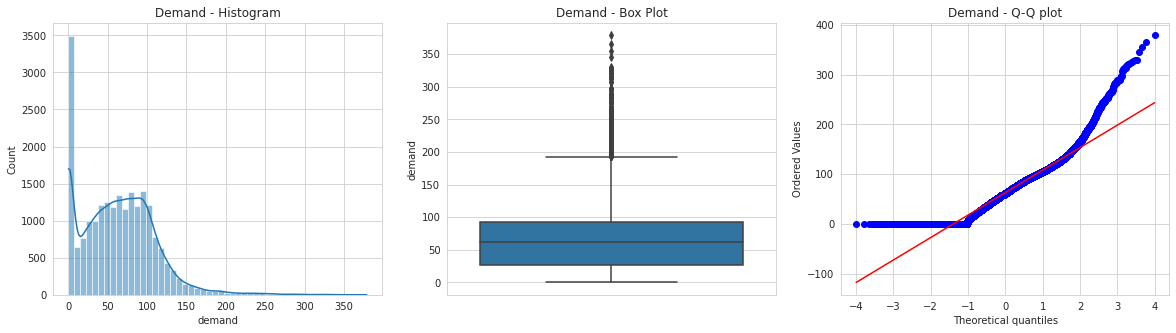

In [54]:
# distribution check
# histogram and box plot
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (20,5))
sns.histplot(x = train_new["demand"], bins=50, kde = True, ax= ax1);
ax1.set_title("Demand - Histogram")
sns.boxplot(y = train_new["demand"], ax= ax2);
ax2.set_title("Demand - Box Plot");
stats.probplot(train_new["demand"], plot = ax3)
ax3.set_title("Demand - Q-Q plot");
plt.show();

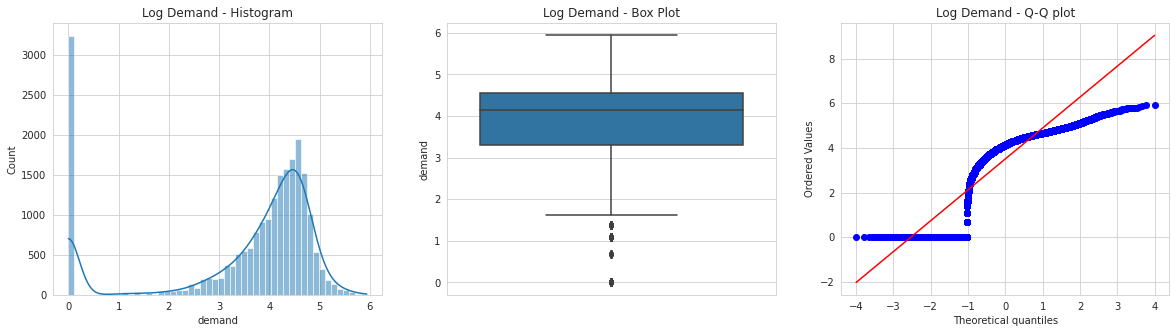

In [55]:
# distribution check - with log transformation
# histogram and box plot
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (20,5))
sns.histplot(x = np.log1p(train_new["demand"]), bins=50, kde = True, ax= ax1);
ax1.set_title("Log Demand - Histogram")
sns.boxplot(y = np.log1p(train_new["demand"]), ax= ax2);
ax2.set_title("Log Demand - Box Plot");
stats.probplot(np.log1p(train_new["demand"]), plot = ax3)
ax3.set_title("Log Demand - Q-Q plot");
plt.show();

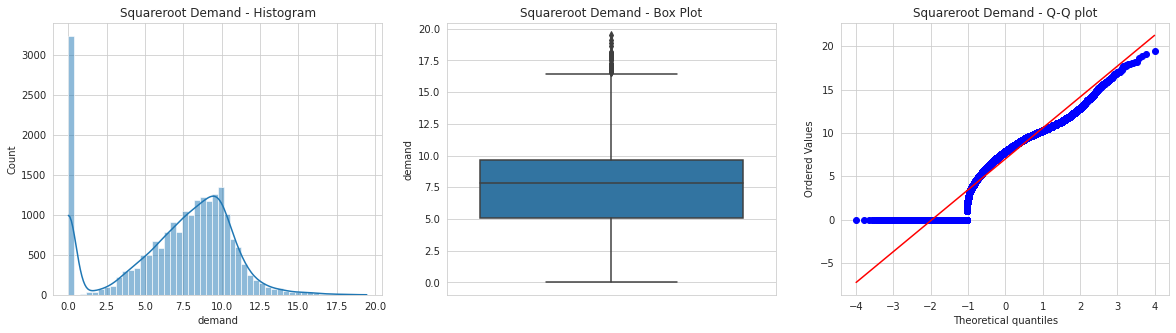

In [56]:
# distribution check - with square root transformation
# histogram and box plot
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (20,5))
sns.histplot(x = np.sqrt(train_new["demand"]), bins=50, kde = True, ax= ax1);
ax1.set_title("Squareroot Demand - Histogram")
sns.boxplot(y = np.sqrt(train_new["demand"]), ax= ax2);
ax2.set_title("Squareroot Demand - Box Plot");
stats.probplot(np.sqrt(train_new["demand"]), plot = ax3)
ax3.set_title("Squareroot Demand - Q-Q plot");
plt.show();

#### Demand trend - Line plot

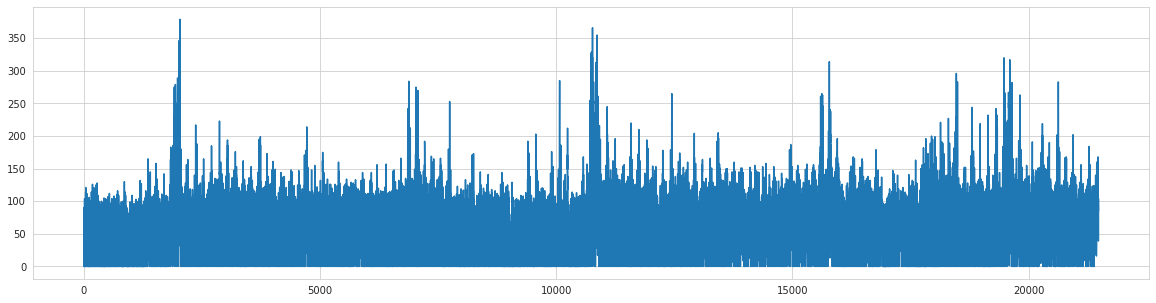

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.figure(figsize = (20,5))
train_new["demand"].plot();

#### Lag and Auto-correlation plot

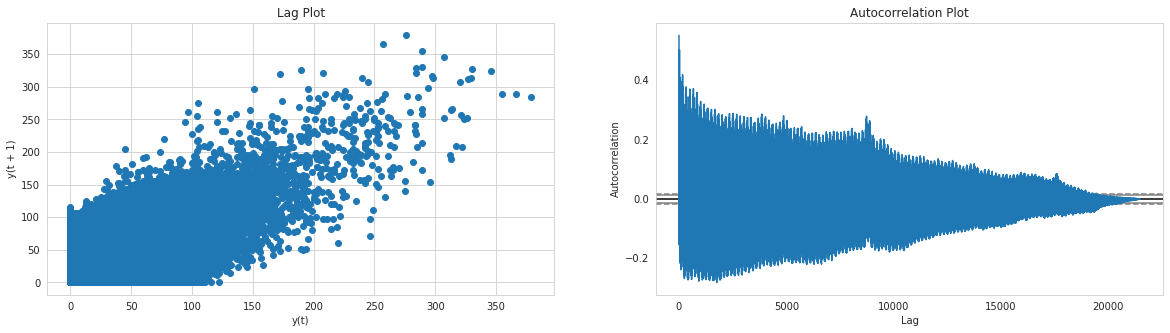

In [58]:
from pandas.plotting import lag_plot, autocorrelation_plot

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,5))
lag_plot(train_new["demand"], ax = ax1)
ax1.set_title("Lag Plot")
autocorrelation_plot(train_new["demand"], ax = ax2)
ax2.set_title("Autocorrelation Plot")
plt.show()

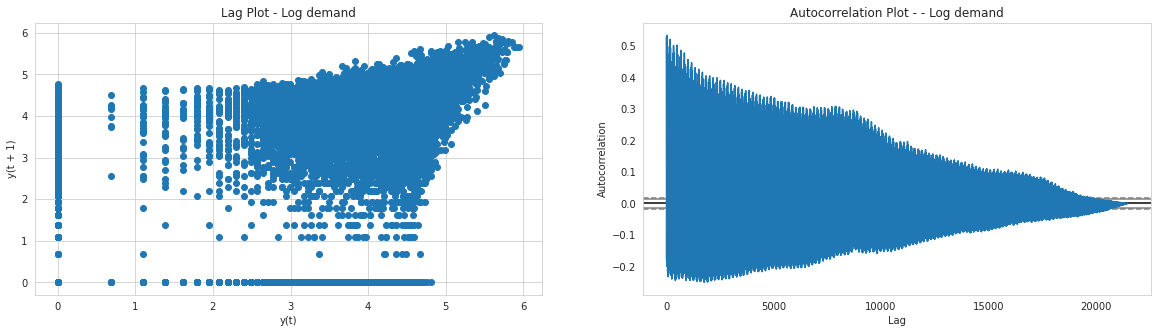

In [59]:
# lag and autocorrelation plot - log transformation
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,5))
lag_plot(np.log1p(train_new["demand"]), ax = ax1)
ax1.set_title("Lag Plot - Log demand")
autocorrelation_plot(np.log1p(train_new["demand"]), ax = ax2)
ax2.set_title("Autocorrelation Plot - - Log demand")
plt.show()

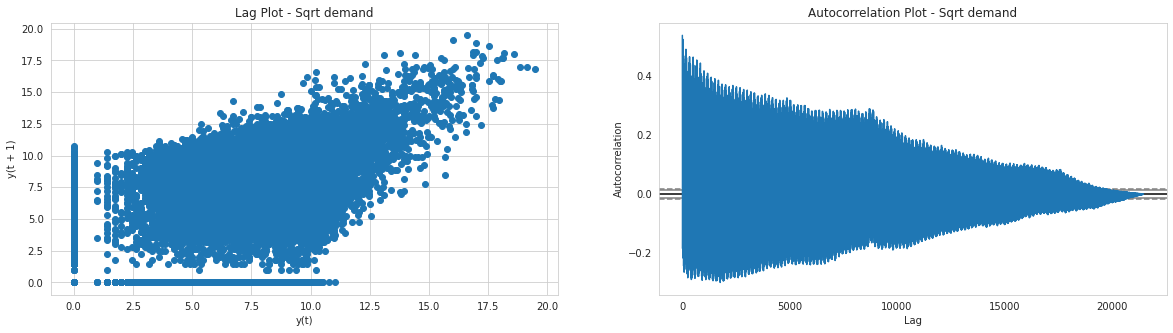

In [60]:
# lag and autocorrelation plot - sqrt transformation
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,5))
lag_plot(np.sqrt(train_new["demand"]), ax = ax1)
ax1.set_title("Lag Plot - Sqrt demand")
autocorrelation_plot(np.sqrt(train_new["demand"]), ax = ax2)
ax2.set_title("Autocorrelation Plot - Sqrt demand")
plt.show()

## 5. <a name="5">Model building</a>
(<a href="#0">Go to top</a>)

Let's start with model building.

### Splitting data into train and validation

We’ll use the last 10% of the data for testing.

In [61]:
train_size = int(len(train_new) * 0.9)
test_size = len(train_new) - train_size

train_df, val_df = train_new.iloc[0:train_size], train_new.iloc[train_size:len(train_new)]
print(len(train_df), len(val_df))

19332 2148


### Creating X and y

In [62]:
# Creating X and y
X_train = train_df.drop(["datetime", "demand"], axis = 1)
y_train = train_df["demand"].values

X_val = val_df.drop(["datetime", "demand"], axis = 1)
y_val = val_df["demand"].values

print("Shape of X_train :", X_train.shape)
print("Shape of y_train :", y_train.shape)

print("Shape of X_val :", X_val.shape)
print("Shape of y_val :", y_val.shape)

Shape of X_train : (19332, 19)
Shape of y_train : (19332,)
Shape of X_val : (2148, 19)
Shape of y_val : (2148,)


### Searching best machine learning algorithm

#### Linear Regression

In [63]:
# itr 1 : linear regression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

# Storing model results
itr_list, train_score_list, val_score_list  = [], [], []

# Linear Regression
model_pipeline = \
Pipeline([('Scaler', StandardScaler()), 
          ('model', LinearRegression())
         ])

# fit model
model = model_pipeline.fit(X_train, y_train)

# making prediction
train_pred = np.around(model.predict(X_train),0).astype(int)
val_pred = np.around(model.predict(X_val),0).astype(int)

# calculating score
train_score = np.sqrt(mean_squared_error(y_train, train_pred))
val_score = np.sqrt(mean_squared_error(y_val, val_pred))
print("training RMSE :", train_score)
print("validation RMSE :", val_score)

# storing results
itr_list.append("Linear Regression")
train_score_list.append(train_score)   
val_score_list.append(val_score)

training RMSE : 42.61651607748159
validation RMSE : 47.19351283419454


#### Linear Regression with L1 regularisation (Lasso)

In [64]:
# itr 2 : lasso
from sklearn.linear_model import Lasso

# Linear Regression with l1 norm
model_pipeline = \
Pipeline([('Scaler', StandardScaler()), 
          ('model', Lasso(random_state = 123))
         ])

# fit model
model = model_pipeline.fit(X_train, y_train)

# making prediction
train_pred = np.around(model.predict(X_train),0).astype(int)
val_pred = np.around(model.predict(X_val),0).astype(int)

# calculating score
train_score = np.sqrt(mean_squared_error(y_train, train_pred))
val_score = np.sqrt(mean_squared_error(y_val, val_pred))
print("training RMSE :", train_score)
print("validation RMSE :", val_score)

# storing results
itr_list.append("Linear Regression with L1 regularisation")
train_score_list.append(train_score)   
val_score_list.append(val_score)

training RMSE : 42.7316734227818
validation RMSE : 47.95616500137113


#### Linear Regression with L2 regularisation (Ridge)

In [65]:
# itr 3 : Ridge
from sklearn.linear_model import Ridge

# Linear Regression with l2 norm
model_pipeline = \
Pipeline([('Scaler', StandardScaler()), 
          ('model', Ridge(random_state = 123))
         ])

# fit model
model = model_pipeline.fit(X_train, y_train)

# making prediction
train_pred = np.around(model.predict(X_train),0).astype(int)
val_pred = np.around(model.predict(X_val),0).astype(int)

# calculating score
train_score = np.sqrt(mean_squared_error(y_train, train_pred))
val_score = np.sqrt(mean_squared_error(y_val, val_pred))
print("training RMSE :", train_score)
print("validation RMSE :", val_score)

# storing results
itr_list.append("Linear Regression with L2 regularisation")
train_score_list.append(train_score)   
val_score_list.append(val_score)

training RMSE : 42.61612705447448
validation RMSE : 47.21663000443584


#### Linear Regression with huber loss (Huber Regression)

In [66]:
# itr 4 : HuberRegressor
from sklearn.linear_model import HuberRegressor

# Huber Regression
model_pipeline = \
Pipeline([('Scaler', StandardScaler()), 
          ('model', HuberRegressor())
         ])

# fit model
model = model_pipeline.fit(X_train, y_train)

# making prediction
train_pred = np.around(model.predict(X_train),0).astype(int)
val_pred = np.around(model.predict(X_val),0).astype(int)

# calculating score
train_score = np.sqrt(mean_squared_error(y_train, train_pred))
val_score = np.sqrt(mean_squared_error(y_val, val_pred))
print("training RMSE :", train_score)
print("validation RMSE :", val_score)

# storing results
itr_list.append("Huber Regressor")
train_score_list.append(train_score)   
val_score_list.append(val_score)

training RMSE : 42.75661080385391
validation RMSE : 47.94699995275277


#### Poisson Regression

In [67]:
# itr 5 : Poisson Regressor
from sklearn.linear_model import PoissonRegressor

# Poisson Regression
model_pipeline = \
Pipeline([('Scaler', StandardScaler()), 
          ('model', PoissonRegressor())
         ])

# fit model
model = model_pipeline.fit(X_train, y_train)

# making prediction
train_pred = np.around(model.predict(X_train),0).astype(int)
val_pred = np.around(model.predict(X_val),0).astype(int)

# calculating score
train_score = np.sqrt(mean_squared_error(y_train, train_pred))
val_score = np.sqrt(mean_squared_error(y_val, val_pred))
print("training RMSE :", train_score)
print("validation RMSE :", val_score)

# storing results
itr_list.append("Poisson Regressor")
train_score_list.append(train_score)   
val_score_list.append(val_score)

training RMSE : 43.23614357592525
validation RMSE : 47.93128228233676


#### KNN Regression

In [68]:
# itr 6 : KNN Regressor
from sklearn.neighbors import KNeighborsRegressor

# Poisson Regression
model_pipeline = \
Pipeline([('Scaler', StandardScaler()), 
          ('model', KNeighborsRegressor())
         ])

# fit model
model = model_pipeline.fit(X_train, y_train)

# making prediction
train_pred = np.around(model.predict(X_train),0).astype(int)
val_pred = np.around(model.predict(X_val),0).astype(int)

# calculating score
train_score = np.sqrt(mean_squared_error(y_train, train_pred))
val_score = np.sqrt(mean_squared_error(y_val, val_pred))
print("training RMSE :", train_score)
print("validation RMSE :", val_score)

# storing results
itr_list.append("K-Neighbors Regressor")
train_score_list.append(train_score)   
val_score_list.append(val_score)

training RMSE : 27.922766549639032
validation RMSE : 44.55010988205072


#### Support Vector Machine with linear kernel

In [69]:
# itr 7 : LinearSVR
from sklearn.svm import LinearSVR

# Poisson Regression
model_pipeline = \
Pipeline([('Scaler', StandardScaler()), 
          ('model', LinearSVR(random_state = 123))
         ])

# fit model
model = model_pipeline.fit(X_train, y_train)

# making prediction
train_pred = np.around(model.predict(X_train),0).astype(int)
val_pred = np.around(model.predict(X_val),0).astype(int)

# calculating score
train_score = np.sqrt(mean_squared_error(y_train, train_pred))
val_score = np.sqrt(mean_squared_error(y_val, val_pred))
print("training RMSE :", train_score)
print("validation RMSE :", val_score)

# storing results
itr_list.append("Linear Support Vector Regressor")
train_score_list.append(train_score)   
val_score_list.append(val_score)

training RMSE : 42.944714458202476
validation RMSE : 47.958756916653805


#### Support Vector Machine with Gaussian kernel

In [70]:
# itr 8 : SVR with gaussian kernel
from sklearn.svm import SVR

# Poisson Regression
model_pipeline = \
Pipeline([('Scaler', StandardScaler()), 
          ('model', SVR())
         ])

# fit model
model = model_pipeline.fit(X_train, y_train)

# making prediction
train_pred = np.around(model.predict(X_train),0).astype(int)
val_pred = np.around(model.predict(X_val),0).astype(int)

# calculating score
train_score = np.sqrt(mean_squared_error(y_train, train_pred))
val_score = np.sqrt(mean_squared_error(y_val, val_pred))
print("training RMSE :", train_score)
print("validation RMSE :", val_score)

# storing results
itr_list.append("Support Vector Regressor with gaussian kernel")
train_score_list.append(train_score)   
val_score_list.append(val_score)

training RMSE : 41.408613066429155
validation RMSE : 47.328692365655215


#### Decision Tree

In [71]:
# itr 9 : Decision Tree
from sklearn.tree import DecisionTreeRegressor

# Poisson Regression
model_pipeline = \
Pipeline([('Scaler', StandardScaler()), 
          ('model', DecisionTreeRegressor(min_samples_leaf = 3, random_state = 123))
         ])

# fit model
model = model_pipeline.fit(X_train, y_train)

# making prediction
train_pred = np.around(model.predict(X_train),0).astype(int)
val_pred = np.around(model.predict(X_val),0).astype(int)

# calculating score
train_score = np.sqrt(mean_squared_error(y_train, train_pred))
val_score = np.sqrt(mean_squared_error(y_val, val_pred))
print("training RMSE :", train_score)
print("validation RMSE :", val_score)

# storing results
itr_list.append("Decision Tree Regressor")
train_score_list.append(train_score)   
val_score_list.append(val_score)

training RMSE : 22.222742855477833
validation RMSE : 44.41004759901459


#### Random Forest

In [72]:
# itr 10 : Random Forest
from sklearn.ensemble import RandomForestRegressor

# RandomForest Regression model
model_pipeline = \
Pipeline([('Scaler', StandardScaler()), 
          ('model', RandomForestRegressor(n_estimators = 500,
                                          criterion = "squared_error",
                                          min_samples_leaf = 3,
                                          n_jobs = -1,
                                          random_state = 123))
         ])

# fit model
model = model_pipeline.fit(X_train, y_train)

# making prediction
train_pred = np.around(model.predict(X_train),0).astype(int)
val_pred = np.around(model.predict(X_val),0).astype(int)

# calculating score
train_score = np.sqrt(mean_squared_error(y_train, train_pred))
val_score = np.sqrt(mean_squared_error(y_val, val_pred))
print("training RMSE :", train_score)
print("validation RMSE :", val_score)

# storing results
itr_list.append("Random Forest Regressor")
train_score_list.append(train_score)   
val_score_list.append(val_score)

training RMSE : 22.425534867898204
validation RMSE : 37.185765983859085


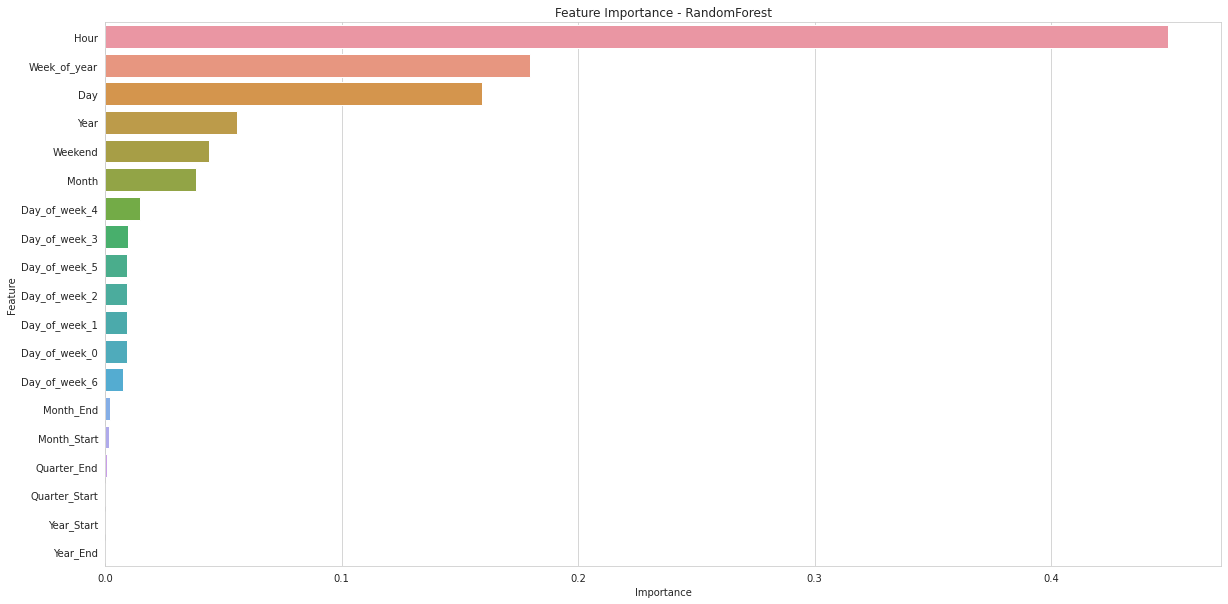

In [73]:
# Feature importance plot
importance = model.named_steps["model"].feature_importances_.tolist()
feature_list = X_train.columns.tolist()
importance_df = pd.DataFrame()
importance_df["Feature"] = feature_list
importance_df["Importance"] = importance
importance_df = importance_df.sort_values(by = "Importance", ascending = False)

plt.figure(figsize = (20,10))
plt.title("Feature Importance - RandomForest")
sns.barplot(x="Importance", y="Feature", data = importance_df);

#### ExtraTrees Regressor

In [74]:
# itr 11 : ExtraTrees Regressor
from sklearn.ensemble import ExtraTreesRegressor

# ExtraTreesRegressor model
model_pipeline = \
Pipeline([('Scaler', StandardScaler()), 
          ('model', ExtraTreesRegressor(n_estimators = 500,
                                        criterion = "squared_error",
                                        min_samples_leaf = 3,
                                        n_jobs = -1,
                                        random_state = 123))
         ])

# fit model
model = model_pipeline.fit(X_train, y_train)

# making prediction
train_pred = np.around(model.predict(X_train),0).astype(int)
val_pred = np.around(model.predict(X_val),0).astype(int)

# calculating score
train_score = np.sqrt(mean_squared_error(y_train, train_pred))
val_score = np.sqrt(mean_squared_error(y_val, val_pred))
print("training RMSE :", train_score)
print("validation RMSE :", val_score)

# storing results
itr_list.append("Extra Trees Regressor")
train_score_list.append(train_score)   
val_score_list.append(val_score)

training RMSE : 21.3571842540958
validation RMSE : 37.80837822080115


#### XGBoost

In [75]:
# itr 12 : XGBoost
from xgboost import XGBRegressor

# RandomForest Regression model
model_pipeline = \
Pipeline([('Scaler', StandardScaler()), 
          ('model', XGBRegressor(objective = 'reg:squarederror',n_estimators = 500,seed = 123, random_state = 123))
         ])

# fit model
model = model_pipeline.fit(X_train, y_train)

# making prediction
train_pred = np.around(model.predict(X_train),0).astype(int)
val_pred = np.around(model.predict(X_val),0).astype(int)

# calculating score
train_score = np.sqrt(mean_squared_error(y_train, train_pred))
val_score = np.sqrt(mean_squared_error(y_val, val_pred))
print("training RMSE :", train_score)
print("validation RMSE :", val_score)

# storing results
itr_list.append("XGBoost Regressor")
train_score_list.append(train_score)   
val_score_list.append(val_score)

training RMSE : 20.356400557519578
validation RMSE : 44.087600075836825


#### Comparing all models

In [76]:
# creating model results df
model_results = \
pd.DataFrame({"Model Name": itr_list, "train_score": train_score_list, "val_score":val_score_list})
model_results.sort_values(by = "val_score")

,Model Name,train_score,val_score
9,Random Forest Regressor,22.43,37.19
10,Extra Trees Regressor,21.36,37.81
11,XGBoost Regressor,20.36,44.09
8,Decision Tree Regressor,22.22,44.41
5,K-Neighbors Regressor,27.92,44.55
0,Linear Regression,42.62,47.19
2,Linear Regression with L2 regularisation,42.62,47.22
7,Support Vector Regressor with gaussian kernel,41.41,47.33
4,Poisson Regressor,43.24,47.93
3,Huber Regressor,42.76,47.95


### Random Forest model : Hyper-parameter tuning

#### n_estimators

In [77]:
# Randomforest hyperparameter tuning - n_estimators
from tqdm import tqdm
train_hp_tuning_score,  val_hp_tuning_score= [], []
n_estimators = [100,200,300,400,500,600,700,800,900,1000]

for n_estimator in tqdm(n_estimators):
    
    # RandomForest Regression model
    model_pipeline = \
    Pipeline([('Scaler', StandardScaler()), 
              ('model', RandomForestRegressor(n_estimators = n_estimator,
                                              criterion = "squared_error",
                                              min_samples_leaf = 3,
                                              n_jobs = -1,
                                              random_state = 123))
             ])

    # fit model
    model = model_pipeline.fit(X_train, y_train)

    # making prediction
    train_pred = np.around(model.predict(X_train),0).astype(int)
    val_pred = np.around(model.predict(X_val),0).astype(int)

    # calculating score
    train_score = np.sqrt(mean_squared_error(y_train, train_pred))
    val_score = np.sqrt(mean_squared_error(y_val, val_pred))

    # storing results
    train_hp_tuning_score.append(train_score)   
    val_hp_tuning_score.append(val_score)

# creating results dataframe
hp_results_df = \
pd.DataFrame(
    {"n_estimators":n_estimators, 
     "train_score":train_hp_tuning_score, 
     "val_score":val_hp_tuning_score})
hp_results_df.sort_values(by = "val_score")

100%|██████████| 10/10 [01:18<00:00,  7.81s/it]


,n_estimators,train_score,val_score
5,600,22.42,37.18
7,800,22.42,37.18
8,900,22.42,37.18
1,200,22.46,37.18
4,500,22.43,37.19
9,1000,22.41,37.19
6,700,22.42,37.19
2,300,22.44,37.21
3,400,22.43,37.21
0,100,22.51,37.25


#### max_features

In [79]:
# Randomforest hyperparameter tuning - n_estimators
from tqdm import tqdm
train_hp_tuning_score,  val_hp_tuning_score= [], []
max_features = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]

for max_feature in tqdm(max_features):
    
    # RandomForest Regression model
    model_pipeline = \
    Pipeline([('Scaler', StandardScaler()), 
              ('model', RandomForestRegressor(n_estimators = 600,
                                              criterion = "squared_error",
                                              max_features = max_feature,
                                              min_samples_leaf = 3,
                                              n_jobs = -1,
                                              random_state = 123))
             ])

    # fit model
    model = model_pipeline.fit(X_train, y_train)

    # making prediction
    train_pred = np.around(model.predict(X_train),0).astype(int)
    val_pred = np.around(model.predict(X_val),0).astype(int)

    # calculating score
    train_score = np.sqrt(mean_squared_error(y_train, train_pred))
    val_score = np.sqrt(mean_squared_error(y_val, val_pred))

    # storing results
    train_hp_tuning_score.append(train_score)   
    val_hp_tuning_score.append(val_score)

# creating results dataframe
hp_results_df = \
pd.DataFrame(
    {"max_features":max_features, 
     "train_score":train_hp_tuning_score, 
     "val_score":val_hp_tuning_score})
hp_results_df.sort_values(by = "val_score")

100%|██████████| 19/19 [01:44<00:00,  5.52s/it]


,max_features,train_score,val_score
4,5,25.12,36.29
5,6,24.86,36.31
6,7,24.58,36.34
3,4,25.30,36.36
7,8,24.30,36.45
8,9,24.02,36.48
2,3,25.42,36.51
9,10,23.78,36.52
10,11,23.56,36.55
11,12,23.36,36.65


#### max_depth

In [81]:
# Randomforest hyperparameter tuning - max_depth
train_hp_tuning_score,  val_hp_tuning_score= [], []
max_depths = [4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

for max_depth in tqdm(max_depths):
    
    # RandomForest Regression model
    model_pipeline = \
    Pipeline([('Scaler', StandardScaler()), 
              ('model', RandomForestRegressor(n_estimators = 600,
                                              criterion = "squared_error",
                                              max_features = 5,
                                              max_depth = max_depth,
                                              min_samples_leaf = 3,
                                              n_jobs = -1,
                                              random_state = 123))
             ])

    # fit model
    model = model_pipeline.fit(X_train, y_train)

    # making prediction
    train_pred = np.around(model.predict(X_train),0).astype(int)
    val_pred = np.around(model.predict(X_val),0).astype(int)

    # calculating score
    train_score = np.sqrt(mean_squared_error(y_train, train_pred))
    val_score = np.sqrt(mean_squared_error(y_val, val_pred))

    # storing results
    train_hp_tuning_score.append(train_score)   
    val_hp_tuning_score.append(val_score)

# creating results dataframe
hp_results_df = \
pd.DataFrame(
    {"max_depths":max_depths, 
     "train_score":train_hp_tuning_score, 
     "val_score":val_hp_tuning_score})
hp_results_df.sort_values(by = "val_score")

100%|██████████| 17/17 [00:48<00:00,  2.87s/it]


,max_depths,train_score,val_score
10,14,27.46,36.07
11,15,26.81,36.08
9,13,28.25,36.08
8,12,29.22,36.09
12,16,26.27,36.15
13,17,25.88,36.20
14,18,25.59,36.21
15,19,25.39,36.23
16,20,25.28,36.23
7,11,30.26,36.33


#### min_samples_leaf

In [82]:
# Randomforest hyperparameter tuning - min_samples_leaf
train_hp_tuning_score,  val_hp_tuning_score= [], []
min_samples_leafs = [3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

for min_samples_leaf in tqdm(min_samples_leafs):
    
    # RandomForest Regression model
    model_pipeline = \
    Pipeline([('Scaler', StandardScaler()), 
              ('model', RandomForestRegressor(n_estimators = 600,
                                              criterion = "squared_error",
                                              max_features = 5,
                                              max_depth = 14,
                                              min_samples_leaf = min_samples_leaf,
                                              n_jobs = -1,
                                              random_state = 123))
             ])

    # fit model
    model = model_pipeline.fit(X_train, y_train)

    # making prediction
    train_pred = np.around(model.predict(X_train),0).astype(int)
    val_pred = np.around(model.predict(X_val),0).astype(int)

    # calculating score
    train_score = np.sqrt(mean_squared_error(y_train, train_pred))
    val_score = np.sqrt(mean_squared_error(y_val, val_pred))

    # storing results
    train_hp_tuning_score.append(train_score)   
    val_hp_tuning_score.append(val_score)

# creating results dataframe
hp_results_df = \
pd.DataFrame(
    {"min_samples_leafs":min_samples_leafs, 
     "train_score":train_hp_tuning_score, 
     "val_score":val_hp_tuning_score})
hp_results_df.sort_values(by = "val_score")

100%|██████████| 18/18 [00:51<00:00,  2.86s/it]


,min_samples_leafs,train_score,val_score
0,3,27.46,36.07
1,4,28.43,36.22
2,5,29.13,36.30
3,6,29.68,36.41
4,7,30.16,36.53
5,8,30.56,36.76
6,9,30.92,36.87
7,10,31.24,37.03
8,11,31.54,37.20
9,12,31.73,37.24


#### min_samples_split

In [83]:
# Randomforest hyperparameter tuning - min_samples_split
train_hp_tuning_score,  val_hp_tuning_score= [], []
min_samples_splits = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]

for min_samples_split in tqdm(min_samples_splits):
    
    # RandomForest Regression model
    model_pipeline = \
    Pipeline([('Scaler', StandardScaler()), 
              ('model', RandomForestRegressor(n_estimators = 600,
                                              criterion = "squared_error",
                                              max_features = 5,
                                              max_depth = 14,
                                              min_samples_leaf = 3,
                                              min_samples_split = min_samples_split,
                                              n_jobs = -1,
                                              random_state = 123))
             ])

    # fit model
    model = model_pipeline.fit(X_train, y_train)

    # making prediction
    train_pred = np.around(model.predict(X_train),0).astype(int)
    val_pred = np.around(model.predict(X_val),0).astype(int)

    # calculating score
    train_score = np.sqrt(mean_squared_error(y_train, train_pred))
    val_score = np.sqrt(mean_squared_error(y_val, val_pred))

    # storing results
    train_hp_tuning_score.append(train_score)   
    val_hp_tuning_score.append(val_score)

# creating results dataframe
hp_results_df = \
pd.DataFrame(
    {"min_samples_splits":min_samples_splits, 
     "train_score":train_hp_tuning_score, 
     "val_score":val_hp_tuning_score})
hp_results_df.sort_values(by = "val_score")

100%|██████████| 19/19 [01:50<00:00,  5.81s/it]


,min_samples_splits,train_score,val_score
5,7,27.66,36.03
0,2,27.46,36.07
1,3,27.46,36.07
2,4,27.46,36.07
3,5,27.46,36.07
4,6,27.46,36.07
6,8,27.90,36.17
8,10,28.42,36.19
7,9,28.14,36.20
9,11,28.63,36.31


#### criterion

In [84]:
# Randomforest hyperparameter tuning - criterion
train_hp_tuning_score,  val_hp_tuning_score= [], []
criterions = ["squared_error", "absolute_error", "poisson"]

for criterion in tqdm(criterions):
    
    # RandomForest Regression model
    model_pipeline = \
    Pipeline([('Scaler', StandardScaler()), 
              ('model', RandomForestRegressor(n_estimators = 600,
                                              criterion = criterion,
                                              max_features = 5,
                                              max_depth = 14,
                                              min_samples_leaf = 3,
                                              min_samples_split = 7,
                                              n_jobs = -1,
                                              random_state = 123))
             ])

    # fit model
    model = model_pipeline.fit(X_train, y_train)

    # making prediction
    train_pred = np.around(model.predict(X_train),0).astype(int)
    val_pred = np.around(model.predict(X_val),0).astype(int)

    # calculating score
    train_score = np.sqrt(mean_squared_error(y_train, train_pred))
    val_score = np.sqrt(mean_squared_error(y_val, val_pred))

    # storing results
    train_hp_tuning_score.append(train_score)   
    val_hp_tuning_score.append(val_score)

# creating results dataframe
hp_results_df = \
pd.DataFrame(
    {"criterions":criterions, 
     "train_score":train_hp_tuning_score, 
     "val_score":val_hp_tuning_score})
hp_results_df.sort_values(by = "val_score")

100%|██████████| 3/3 [05:22<00:00, 107.49s/it]


,criterions,train_score,val_score
0,squared_error,27.66,36.03
1,absolute_error,28.44,37.15
2,poisson,35.36,37.86


In [87]:
# training with final set of hyperparameter
# RandomForest Regression model
model_pipeline = \
Pipeline([('Scaler', StandardScaler()), 
          ('model', RandomForestRegressor(n_estimators = 600,
                                          criterion = "squared_error",
                                          max_features = 5,
                                          max_depth = 14,
                                          min_samples_leaf = 3,
                                          min_samples_split = 7,
                                          n_jobs = -1,
                                          random_state = 123))
         ])

# fit model
model = model_pipeline.fit(X_train, y_train)

# making prediction
train_pred = np.around(model.predict(X_train),0).astype(int)
val_pred = np.around(model.predict(X_val),0).astype(int)

# calculating score
train_score = np.sqrt(mean_squared_error(y_train, train_pred))
val_score = np.sqrt(mean_squared_error(y_val, val_pred))
print("training RMSE :", train_score)
print("validation RMSE :", val_score)

training RMSE : 27.65692113326224
validation RMSE : 36.02957609822109


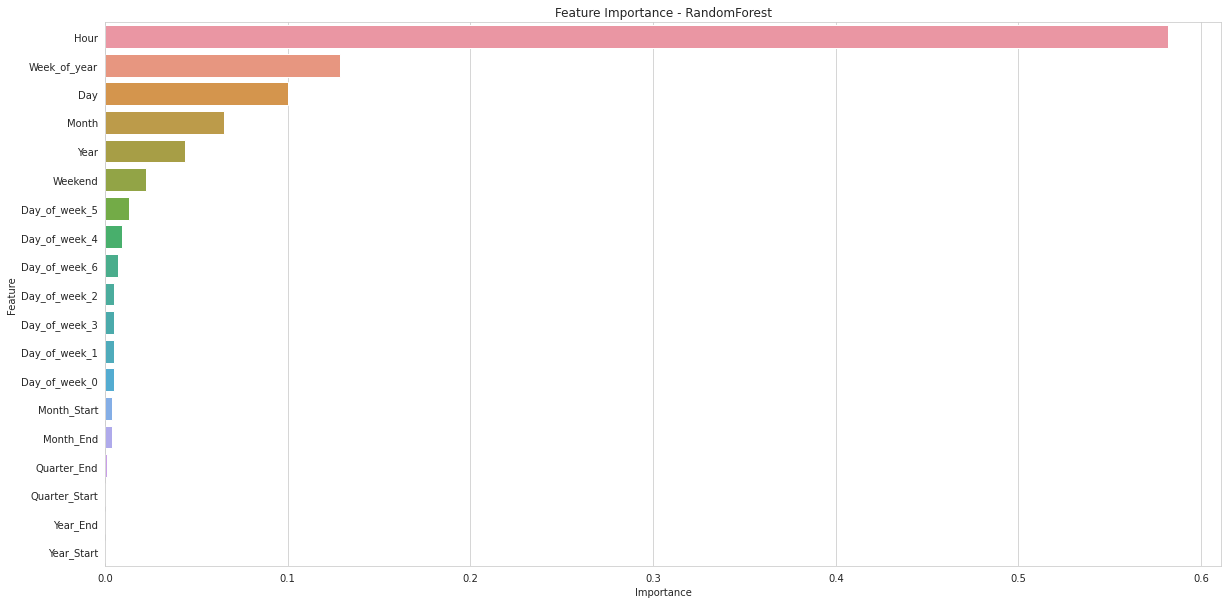

In [88]:
# Feature importance plot
importance = model.named_steps["model"].feature_importances_.tolist()
feature_list = X_train.columns.tolist()
importance_df = pd.DataFrame()
importance_df["Feature"] = feature_list
importance_df["Importance"] = importance
importance_df = importance_df.sort_values(by = "Importance", ascending = False)

plt.figure(figsize = (20,10))
plt.title("Feature Importance - RandomForest")
sns.barplot(x="Importance", y="Feature", data = importance_df);

*****
> **Random Forest Regressor** is found as most effective model with below set of hyperparameters:

|Hyperparameter|value|
|:------------:|:----:|
|n_estimators|600|
|criterion|squared_error|
|max_features|5|
|max_depth|14|
|min_samples_leaf|3|
|min_samples_split|7|
|n_jobs|-1|
|random_state|123|
*****

## 6. <a name="6">Final model</a>
(<a href="#0">Go to top</a>)

Let's retrain with all samples using tuned Randomforest model.

In [89]:
# Creating X and y
X_train = train_new.drop(["datetime", "demand"], axis = 1)
y_train = train_new["demand"].values

print("Shape of X_train :", X_train.shape)
print("Shape of y_train :", y_train.shape)

Shape of X_train : (21480, 19)
Shape of y_train : (21480,)


In [90]:
# training with final set of hyperparameter
# RandomForest Regression model
model_pipeline = \
Pipeline([('Scaler', StandardScaler()), 
          ('model', RandomForestRegressor(n_estimators = 600,
                                          criterion = "squared_error",
                                          max_features = 5,
                                          max_depth = 14,
                                          min_samples_leaf = 3,
                                          min_samples_split = 7,
                                          n_jobs = -1,
                                          random_state = 123))
         ])

# fit model
model = model_pipeline.fit(X_train, y_train)

# making prediction
train_pred = np.around(model.predict(X_train),0).astype(int)

# calculating score
train_score = np.sqrt(mean_squared_error(y_train, train_pred))
print("training RMSE :", train_score)

training RMSE : 27.960052309315603


## 7. <a name="7">Creating submission file</a>
(<a href="#0">Go to top</a>)

Let's predict on test data and create submission file.

In [93]:
# Creating X and y
X_test = test.drop(["datetime", "date", "hour"], axis = 1)
print("Shape of X_test :", X_test.shape)

Shape of X_test : (7650, 19)


In [95]:
# making prediction
test_pred = np.around(model.predict(X_test),0).astype(int)

In [97]:
# merging prediction into test data
test["demand"] = test_pred
submission_file = test[["date", "hour", "demand"]]
submission_file.head()

,date,hour,demand
0,2021-03-01,0,56
1,2021-03-01,1,42
2,2021-03-01,2,39
3,2021-03-01,3,33
4,2021-03-01,5,34


In [98]:
# creating submission file
submission_file.to_csv('../output/submission_v1.csv', index = False)